In [1]:
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import pathlib

import keras_tuner as kt

2023-04-06 23:37:25.295530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 23:37:25.814341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def model_builder(hp):
    blocks = hp.Int('blocks', min_value=3, max_value=4, step=1)
    data_augmentation = keras.Sequential([
        layers.RandomRotation(hp.Float('rotation', min_value=0.05, max_value=0.2, step=0.05)),
        layers.RandomFlip(),
        layers.RandomContrast(hp.Float('contrast', min_value=0.05, max_value=0.2, step=0.05)),
        layers.RandomBrightness(hp.Float('brightness', min_value=0.05, max_value=0.2, step=0.05)),
        layers.RandomZoom(hp.Float('zoom', min_value=0, max_value=0.2, step=0.05)),
    ])

    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    for i in range(blocks + 1, blocks + 5):
        x = layers.Conv2D(filters=2**i, kernel_size=3,
                          kernel_initializer=initializers.GlorotNormal(seed=123), 
                          activation="relu")(x)
        x = layers.Conv2D(filters=2**i, kernel_size=3, use_bias=False,
                          kernel_initializer=initializers.GlorotNormal(seed=123))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
        x = layers.Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(30, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return model


In [3]:
tuner = kt.BayesianOptimization(
            model_builder,
            objective='val_loss',
            max_trials=15,
            overwrite=True)

2023-04-06 23:37:55.860888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 23:37:55.878207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 23:37:55.878372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
dataset_path = pathlib.Path("moths")
input_shape = (224,224,3)
batch_size=64

train_dataset = image_dataset_from_directory(
    dataset_path / "train",
    image_size=input_shape[:2],
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    dataset_path / "valid",
    image_size=input_shape[:2],
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    dataset_path / "test",
    image_size=input_shape[:2],
    batch_size=batch_size)

Found 3558 files belonging to 30 classes.
Found 445 files belonging to 30 classes.
Found 408 files belonging to 30 classes.


In [5]:
tuner.search(x=train_dataset, epochs=20, validation_data=validation_dataset)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 15 Complete [00h 02m 19s]
val_loss: 0.7281265258789062

Best val_loss So Far: 0.7281265258789062
Total elapsed time: 00h 42m 52s
INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 14 summary
Hyperparameters:
blocks: 3
rotation: 0.1
contrast: 0.15000000000000002
brightness: 0.15000000000000002
zoom: 0.2
dropout: 0.2
learning_rate: 0.001
Score: 0.7281265258789062

Trial 10 summary
Hyperparameters:
blocks: 3
rotation: 0.15000000000000002
contrast: 0.2
brightness: 0.1
zoom: 0.1
dropout: 0.2
learning_rate: 0.001
Score: 0.8204528093338013

Trial 07 summary
Hyperparameters:
blocks: 3
rotation: 0.1
contrast: 0.2
brightness: 0.15000000000000002
zoom: 0.2
dropout: 0.1
learning_rate: 0.001
Score: 0.8333144187927246

Trial 13 summary
Hyperparameters:
blocks: 4
rotation: 0.05
contrast: 0.2
brightness: 0.2
zoom: 0.05
dropout: 0.0
learning_rate: 0.0001
Score: 0.8442155122756958

Trial 02 summary
Hyperparameters:
blocks: 4
rotation: 0.05
contrast: 0.15000000000000002
brightness: 0.1
zoom: 0.15000000000000002
dropout: 0.2
learning_rate: 0.001
Score: 0.974988281

In [6]:
best_model.build(input_shape=(224, 224, 3))
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2304      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 16)     64        
 ormalization)                                                   
                                                             

In [7]:
model_best_hps = model_builder(best_hyperparameters)

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="saved_models/model_tuned.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(
        patience=30,
        monitor='val_loss'
    )
]

history = model_best_hps.fit(
                train_dataset,
                epochs=200,
                batch_size=64,
                validation_data=validation_dataset,
                callbacks=callbacks
)

Epoch 1/200


2023-04-07 06:37:47.745564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 9s 124ms/step - loss: 3.6138 - accuracy: 0.2052 - val_loss: 4.9600 - val_accuracy: 0.0427
Epoch 2/200
56/56 [==============================] - 7s 120ms/step - loss: 2.3612 - accuracy: 0.3623 - val_loss: 8.7740 - val_accuracy: 0.0404
Epoch 3/200
56/56 [==============================] - 7s 120ms/step - loss: 1.8943 - accuracy: 0.4539 - val_loss: 8.1683 - val_accuracy: 0.0607
Epoch 4/200
56/56 [==============================] - 7s 121ms/step - loss: 1.6007 - accuracy: 0.5188 - val_loss: 7.0415 - val_accuracy: 0.1461
Epoch 5/200
56/56 [==============================] - 7s 122ms/step - loss: 1.4437 - accuracy: 0.5658 - val_loss: 4.8755 - val_accuracy: 0.1371
Epoch 6/200
56/56 [==============================] - 7s 122ms/step - loss: 1.3259 - accuracy: 0.5953 - val_loss: 3.4937 - val_accuracy: 0.2607
Epoch 7/200
56/56 [==============================] - 7s 122ms/step - loss: 1.2216 - accuracy: 0.6313 - val_loss: 1.6532 - val_accuracy: 0.4899
Epoch 8/200

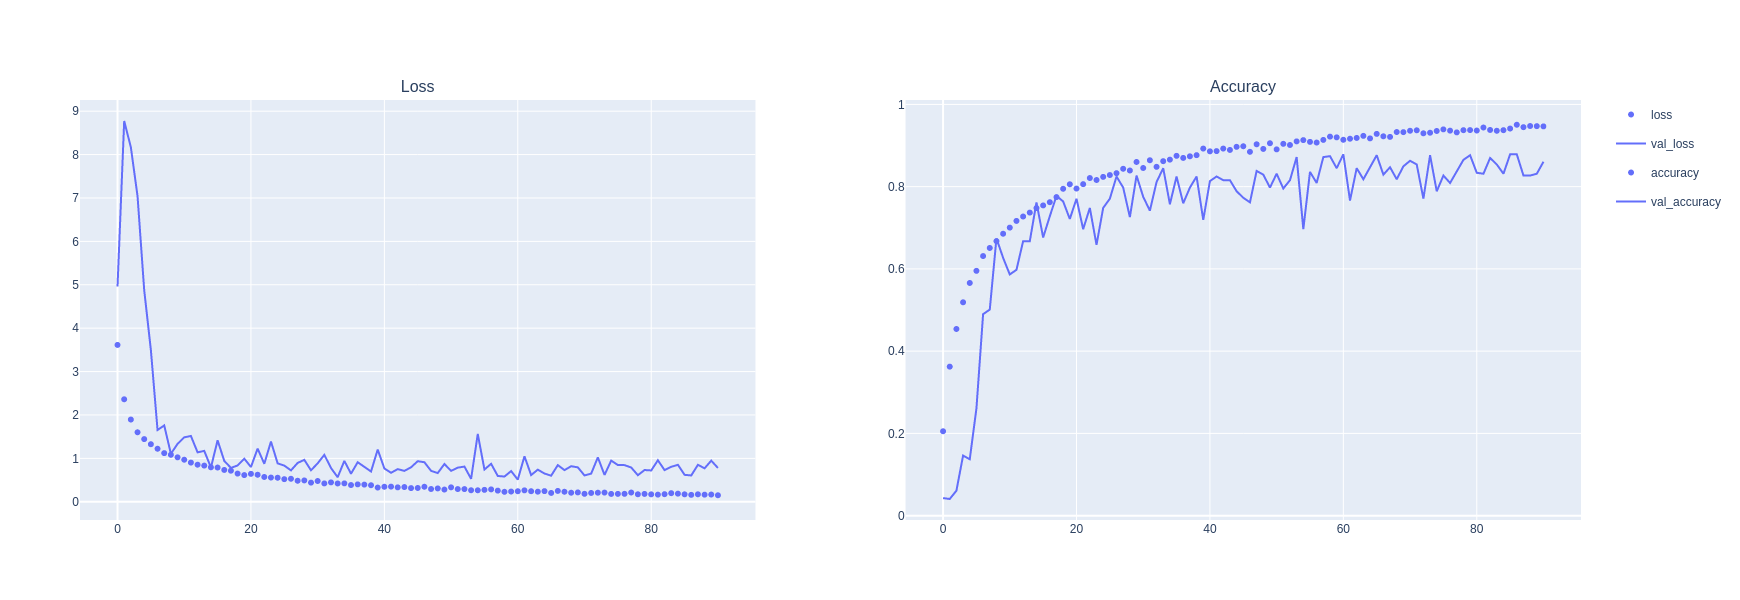

In [11]:
hist_df = pd.DataFrame(history.history)
loss = px.scatter(hist_df['loss'])
val_loss = px.line(hist_df['val_loss'])
accuracy = px.scatter(hist_df['accuracy'])
val_accuracy = px.line(hist_df['val_accuracy'])

fig = make_subplots(cols=2, rows=1, subplot_titles=("Loss", "Accuracy"))
fig.add_trace(loss.data[0], col=1, row=1)
fig.add_trace(val_loss.data[0], col=1, row=1)
fig.add_trace(accuracy.data[0], col=2, row=1)
fig.add_trace(val_accuracy.data[0], col=2, row=1)
fig.update_layout(height=600)

fig.show()

In [13]:
model_A = load_model("saved_models/model_handcrafted_A.keras")
model_B = load_model("saved_models/model_handcrafted_B.keras")
model_C = load_model("saved_models/model_handcrafted_C.keras")
model_D = load_model("saved_models/model_handcrafted_D.keras")
model_E = load_model("saved_models/model_handcrafted_E.keras")
model_tuned = load_model("saved_models/model_tuned.keras")

_, model_A_acc = model_A.evaluate(test_dataset)
_, model_B_acc = model_B.evaluate(test_dataset)
_, model_C_acc = model_C.evaluate(test_dataset)
_, model_D_acc = model_D.evaluate(test_dataset)
_, model_E_acc = model_E.evaluate(test_dataset)
_, model_tuned_acc = model_tuned.evaluate(test_dataset)

print(
    f"Model A: {model_A_acc * 100:.2f}% of accuracy\n"
    f"Model B: {model_B_acc * 100:.2f}% of accuracy\n"
    f"Model C: {model_C_acc * 100:.2f}% of accuracy\n"
    f"Model D: {model_D_acc * 100:.2f}% of accuracy\n"
    f"Model E: {model_E_acc * 100:.2f}% of accuracy\n"
    f"Model tuned: {model_tuned_acc * 100:.2f}% of accuracy"
      )

7/7 [==============================] - 0s 26ms/step - loss: 0.5723 - accuracy: 0.8529
Model A: 69.85% of accuracy
Model B: 64.95% of accuracy
Model C: 83.33% of accuracy
Model D: 1.72% of accuracy
Model E: 83.82% of accuracy
Model tuned: 85.29% of accuracy
